In [246]:
np.std(np.array([
    65.02, 56.83, 60,58.46, 60.55, 56.44, 61.99
]))

2.789907466829211

In [1]:
CUDA_LAUNCH_BLOCKING="1"

In [2]:
import pandas as pd
import os
import nibabel as nib
import pydicom as dicom
import h5py
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
import torch.nn.functional as F
from tqdm.notebook import tqdm_notebook
from torch.cuda.amp import GradScaler, autocast
import wandb
from skimage.transform import resize
from sklearn.metrics import roc_auc_score
from loguru import logger
import random
from monai.networks.nets import EfficientNetBN
from monai.networks.nets import resnet10, resnet18, resnet34
import time
from sklearn.model_selection import train_test_split
from monai import transforms 
import albumentations as A

In [3]:
torch.manual_seed(383)
random.seed(383)
np.random.seed(383)

# Read data

In [4]:
df = pd.read_csv("Data/MGMT_2D_SLICES.csv")
df.head()

,patient_id,x,y,target,slice_pixel_count,slice_tumor_pixel_count,slice
0,BraTS2021_00000,Data/Slices/BraTS2021_00000/x/0.h5,Data/Slices/BraTS2021_00000/y/0.h5,BACKGROUND,0.0,0.0,0
1,BraTS2021_00000,Data/Slices/BraTS2021_00000/x/1.h5,Data/Slices/BraTS2021_00000/y/1.h5,BACKGROUND,0.0,0.0,1
2,BraTS2021_00000,Data/Slices/BraTS2021_00000/x/2.h5,Data/Slices/BraTS2021_00000/y/2.h5,BACKGROUND,0.0,0.0,2
3,BraTS2021_00000,Data/Slices/BraTS2021_00000/x/3.h5,Data/Slices/BraTS2021_00000/y/3.h5,BACKGROUND,0.0,0.0,3
4,BraTS2021_00000,Data/Slices/BraTS2021_00000/x/4.h5,Data/Slices/BraTS2021_00000/y/4.h5,BACKGROUND,6.0,0.0,4


In [5]:
df["binary_target"] = df.groupby("patient_id")["target"].transform(lambda x: 1 if "MGMT - YES" in list(set(x)) else 0)

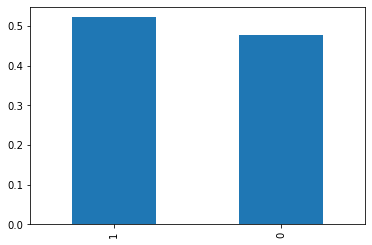

In [6]:
df["binary_target"].value_counts(normalize=True).plot.bar()
plt.show()

In [7]:
df.head()

,patient_id,x,y,target,slice_pixel_count,slice_tumor_pixel_count,slice,binary_target
0,BraTS2021_00000,Data/Slices/BraTS2021_00000/x/0.h5,Data/Slices/BraTS2021_00000/y/0.h5,BACKGROUND,0.0,0.0,0,1
1,BraTS2021_00000,Data/Slices/BraTS2021_00000/x/1.h5,Data/Slices/BraTS2021_00000/y/1.h5,BACKGROUND,0.0,0.0,1,1
2,BraTS2021_00000,Data/Slices/BraTS2021_00000/x/2.h5,Data/Slices/BraTS2021_00000/y/2.h5,BACKGROUND,0.0,0.0,2,1
3,BraTS2021_00000,Data/Slices/BraTS2021_00000/x/3.h5,Data/Slices/BraTS2021_00000/y/3.h5,BACKGROUND,0.0,0.0,3,1
4,BraTS2021_00000,Data/Slices/BraTS2021_00000/x/4.h5,Data/Slices/BraTS2021_00000/y/4.h5,BACKGROUND,6.0,0.0,4,1


In [8]:
train = pd.read_csv("Data/TRAIN.csv")
# val = pd.read_csv("Data/VAL.csv")
test = pd.read_csv("Data/TEST.csv")

In [9]:
df_train = df[df["patient_id"].isin(train["files"].to_list())].sample(frac=1, random_state=0).reset_index(drop=True)
# df_val = df[df["patient_id"].isin(val["files"].to_list())].sample(frac=1, random_state=0).reset_index(drop=True)
df_test = df[df["patient_id"].isin(test["files"].to_list())].sample(frac=1, random_state=0).reset_index(drop=True)

In [10]:
df_train = df_train[df_train["slice_pixel_count"] > 0]
df_test = df_test[df_test["slice_pixel_count"] > 0]

In [11]:
# train_patients_selected = pd.Series(df_train["patient_id"].unique()).sample(frac=0.75, random_state=0).tolist()
train_patients_selected = pd.Series(df_train["patient_id"].unique()).sample(frac=0.75).tolist()

df_train_val = df_train[df_train["patient_id"].isin(train_patients_selected)].sample(frac=1).reset_index(drop=True)
df_val = df_train[~df_train["patient_id"].isin(train_patients_selected)].sample(frac=1).reset_index(drop=True)

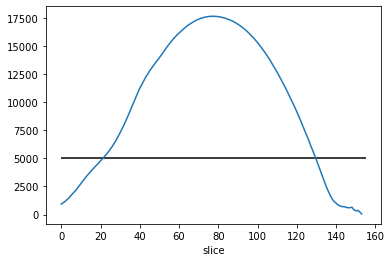

In [12]:
df_train_val.groupby("slice")["slice_pixel_count"].mean().plot()
plt.hlines(5000, 0, 155)
plt.show()

In [13]:
thr_pixel_count = df_train_val.groupby("slice")["slice_pixel_count"].median().quantile(0.30)

print(f"Pixel number: {thr_pixel_count}")

Pixel number: 5010.0


In [14]:
df_train_val["slice_tumor_pixel_count"].mean()

681.6810379065355

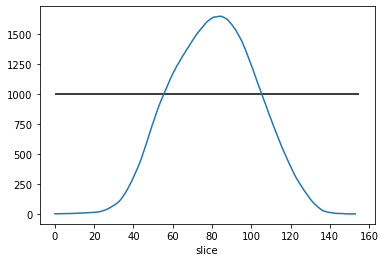

In [15]:
df_train_val.groupby("slice")["slice_tumor_pixel_count"].mean().plot()
plt.hlines(1000, 0, 155)
plt.show()

In [16]:
thr_tumor_pixel_count = df_train_val.groupby("slice")["slice_tumor_pixel_count"].median().quantile(0.50)

print(f"Pixel number: {thr_tumor_pixel_count}")

Pixel number: 0.0


In [17]:
thr_tumor_pixel_count = 50

In [18]:
df_train_val = df_train_val[df_train_val["slice_pixel_count"] > thr_pixel_count].reset_index(drop=True)
df_val = df_val[df_val["slice_pixel_count"] > thr_pixel_count].reset_index(drop=True)
df_test = df_test[df_test["slice_pixel_count"] > thr_pixel_count].reset_index(drop=True)

df_train_val = df_train_val[(df_train_val["slice_tumor_pixel_count"] > thr_tumor_pixel_count) | (df_train_val["target"] == "BACKGROUND")].reset_index(drop=True)
df_val = df_val[(df_val["slice_tumor_pixel_count"] > thr_tumor_pixel_count) | (df_val["target"] == "BACKGROUND")].reset_index(drop=True)
df_test = df_test[(df_test["slice_tumor_pixel_count"] > thr_tumor_pixel_count) | (df_test["target"] ==  "BACKGROUND")].reset_index(drop=True)

In [19]:
df_train_val["target"].value_counts(normalize=True)

BACKGROUND    0.425481
MGMT - YES    0.289563
MGMT - NO     0.284955
Name: target, dtype: float64

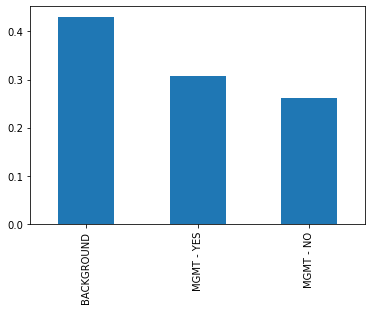

In [20]:
df_test["target"].value_counts(normalize=True).plot.bar()

In [21]:
df_sel = df_val[df_val["patient_id"] == "BraTS2021_00571"].sort_values(by="slice").reset_index(drop=True)

In [22]:
df_sel.sort_values(by="slice_pixel_count", ascending=True).head()

,patient_id,x,y,target,slice_pixel_count,slice_tumor_pixel_count,slice,binary_target
71,BraTS2021_00571,Data/Slices/BraTS2021_00571/x/128.h5,Data/Slices/BraTS2021_00571/y/128.h5,BACKGROUND,5384.0,0.0,128,0
0,BraTS2021_00571,Data/Slices/BraTS2021_00571/x/55.h5,Data/Slices/BraTS2021_00571/y/55.h5,BACKGROUND,5646.0,0.0,55,0
70,BraTS2021_00571,Data/Slices/BraTS2021_00571/x/127.h5,Data/Slices/BraTS2021_00571/y/127.h5,BACKGROUND,6223.0,0.0,127,0
1,BraTS2021_00571,Data/Slices/BraTS2021_00571/x/56.h5,Data/Slices/BraTS2021_00571/y/56.h5,BACKGROUND,6477.0,0.0,56,0
69,BraTS2021_00571,Data/Slices/BraTS2021_00571/x/126.h5,Data/Slices/BraTS2021_00571/y/126.h5,BACKGROUND,6956.0,0.0,126,0


0


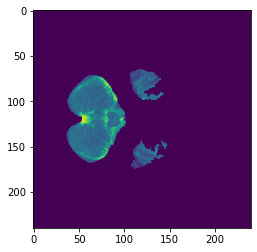

1


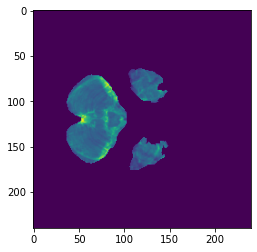

2


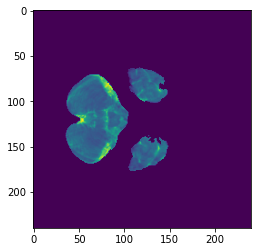

3


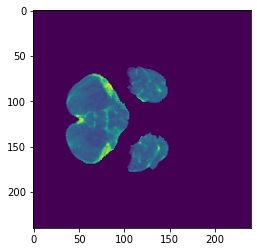

4


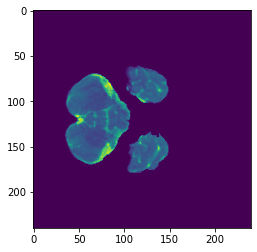

5


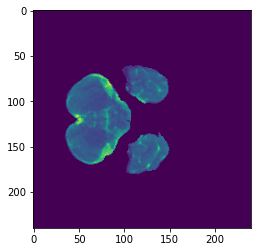

6


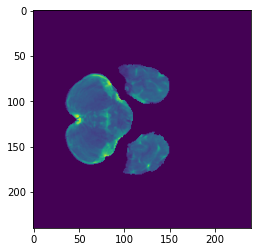

7


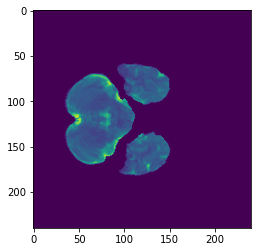

8


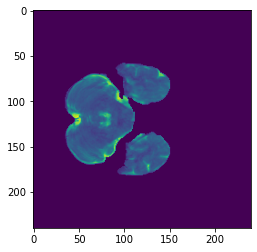

9


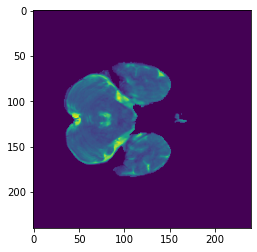

10


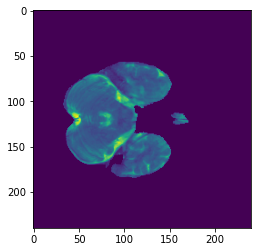

11


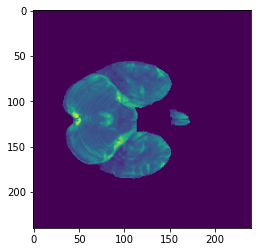

12


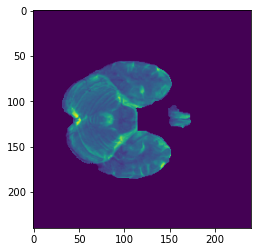

13


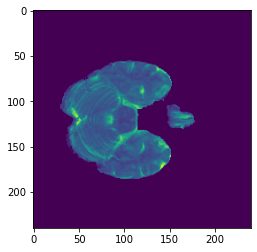

14


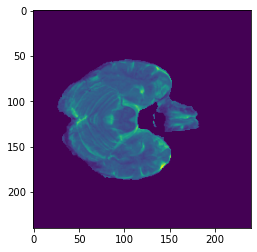

15


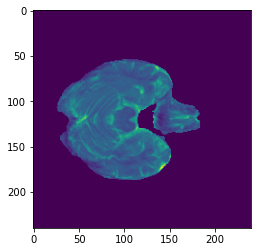

16


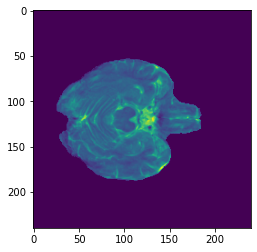

17


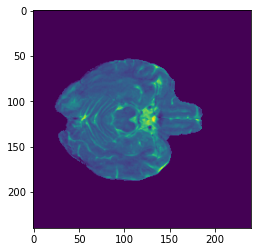

18


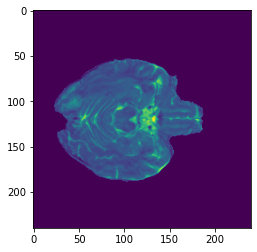

19


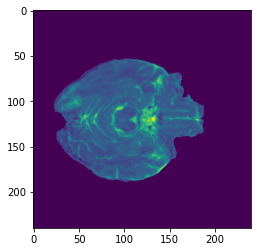

20


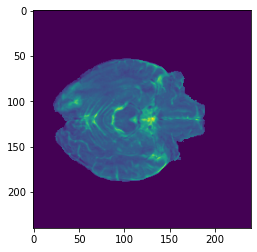

21


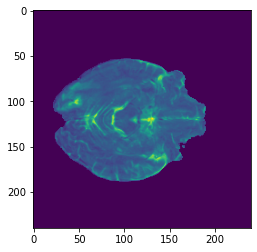

22


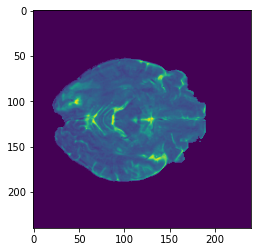

23


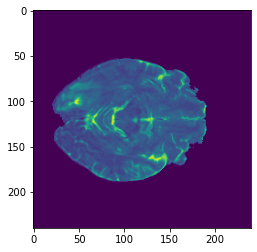

24


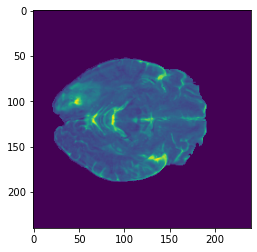

25


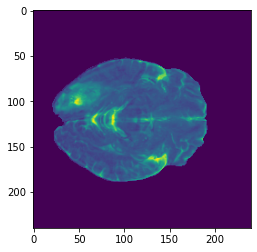

26


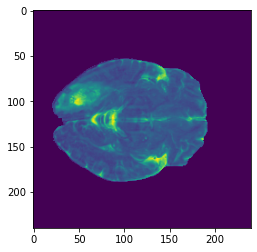

27


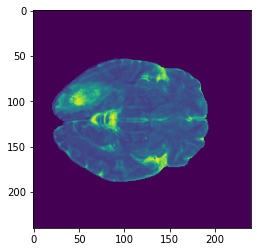

28


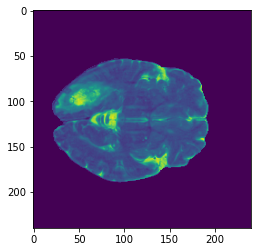

29


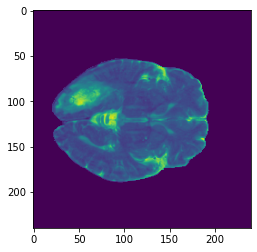

30


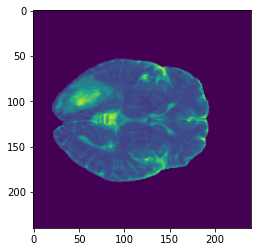

31


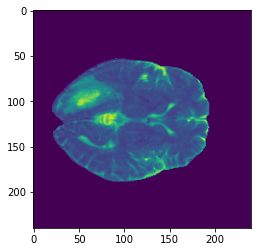

32


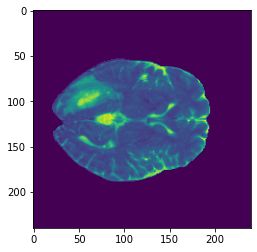

33


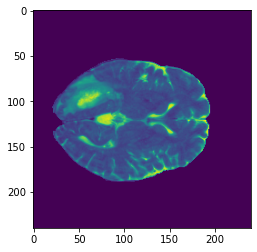

34


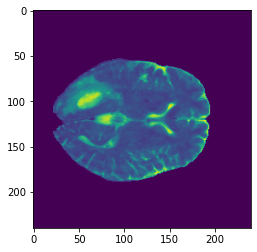

35


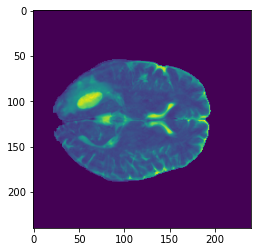

36


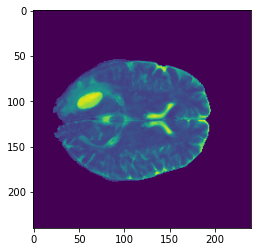

37


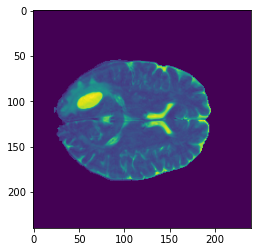

38


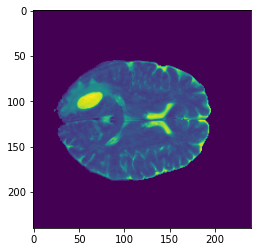

39


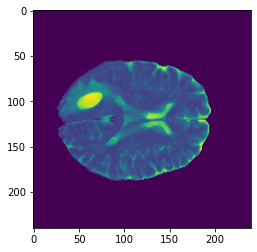

40


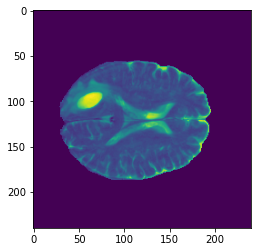

41


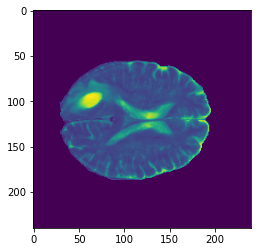

42


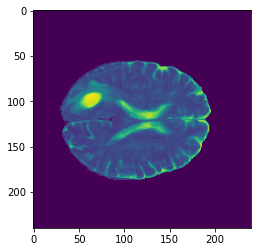

43


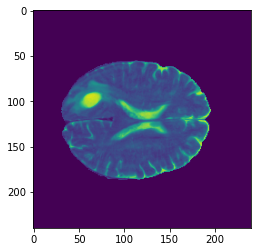

44


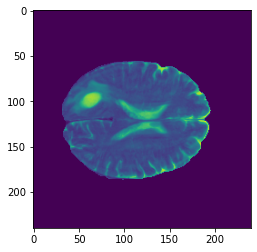

45


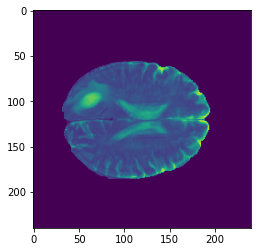

46


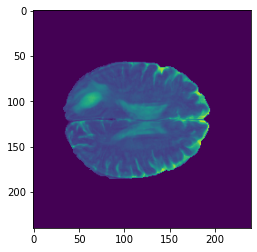

47


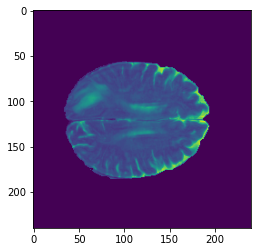

48


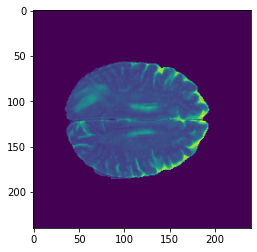

49


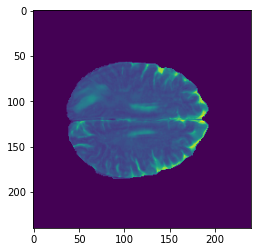

50


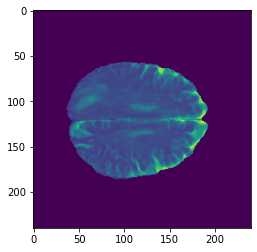

51


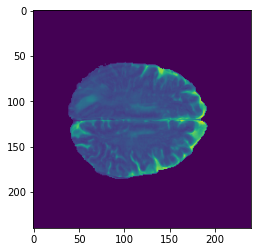

52


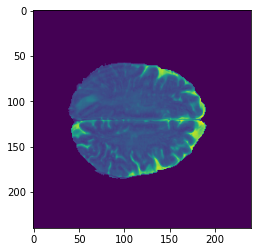

53


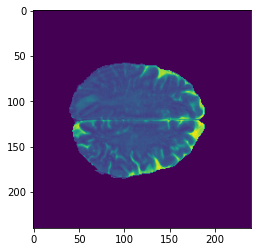

54


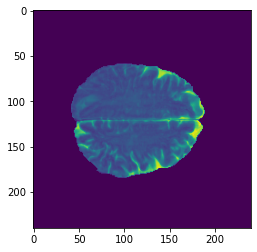

55


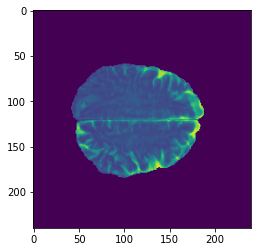

56


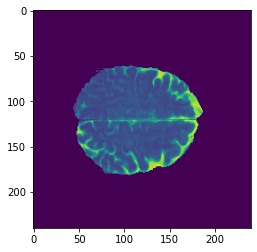

57


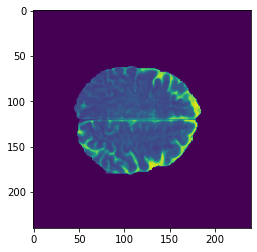

58


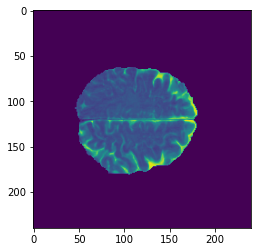

59


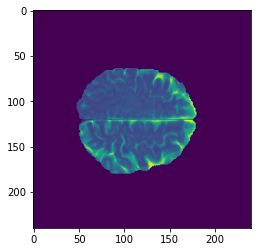

60


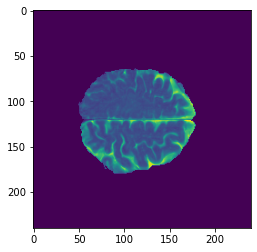

61


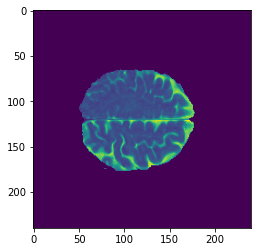

62


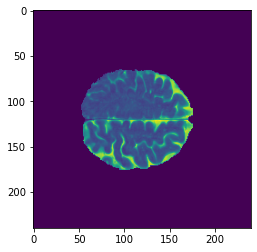

63


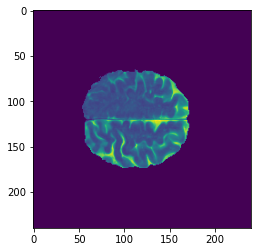

64


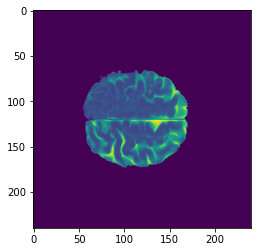

65


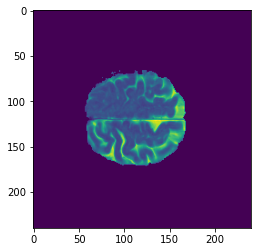

66


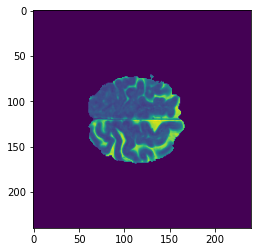

67


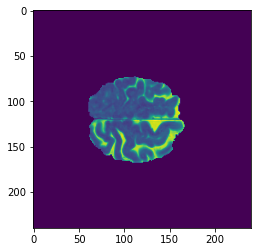

68


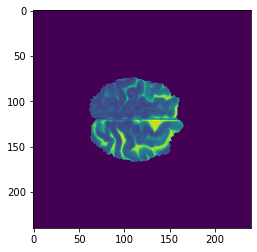

69


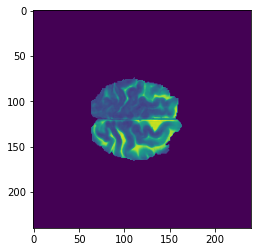

70


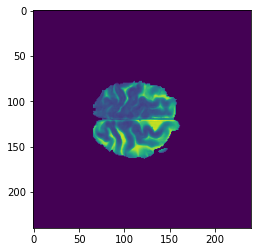

71


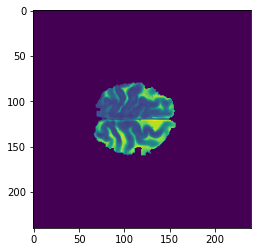

In [23]:
for i in range(df_sel.shape[0]):

    print(i)
    
    with h5py.File(df_sel["x"][i], "r") as f:
        a_group_key = list(f.keys())[0]
        x = np.array(list(f[a_group_key]))

    plt.imshow(x)
    plt.show()

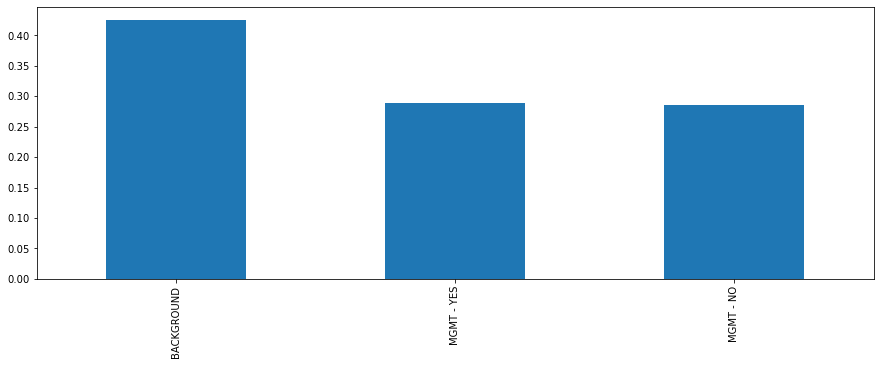

In [24]:
df_train_val["target"].value_counts(normalize=True).plot.bar(figsize=(15, 5))
plt.show()

# Custom data loader

In [25]:
class MRI_LoaderAugmentation(Dataset):
    def __init__(self, brain, target, transform):
        self.files_brain = brain
        self.target = target
        self.transform = transform

    def __len__(self):
        return len(self.files_brain)
    
    def process_target_value(self, value):
        
        if value == "BACKGROUND":
            return 0
        elif value == "MGMT - NO":
            return 1
        elif value == "MGMT - YES":
            return 2
    
    def __getitem__(self, idx):
        
        x = self.files_brain[idx] 
        y = self.target[idx]
                
        y = self.process_target_value(y)
            
        with h5py.File(x, "r") as f:
            a_group_key = list(f.keys())[0]
            x = np.array(list(f[a_group_key]))
        
#         x = x[25:200, 30:205] #Crop slice
            
        if self.transform is not None:
            
            x = np.expand_dims(x, 0)
            
            x = self.transform(x)
            
            x = x[0]
    
        x = (x - x.mean())/(x.std() + 1e-6)

        return {
            "x": torch.tensor(x).unsqueeze(dim=0), 
            "y": torch.tensor(y).long(),
            "id": self.files_brain[idx].split("/")[2]
        }

In [26]:
PROB = 1

TR = transforms.Compose(
#     [
#         transforms.RandRotate(prob=PROB, 
#                               range_x=(15*np.pi/180),
#                               range_y=(15*np.pi/180),
#                               range_z=(15*np.pi/180),
#                              ),
#         transforms.Rand3DElastic(
#             prob=PROB,
#             sigma_range=(0.1, 0.25),
#             magnitude_range=(0.05, 0.1)
#         ),
#         transforms.RandZoom(prob=PROB, min_zoom=0.5, max_zoom=1.75),
        transforms.RandGaussianNoise(prob=PROB, mean=250, std=250),
#         transforms.RandBiasField(prob=PROB, coeff_range=(0, 1)),
#         transforms.RandCoarseDropout(prob=PROB, holes=16, spatial_size=(16, 16), fill_value=0)        
#     ]
)

## Test data loader

In [27]:
df_temp = df_train_val.iloc[:10].copy()
df_temp.head()

,patient_id,x,y,target,slice_pixel_count,slice_tumor_pixel_count,slice,binary_target
0,BraTS2021_00030,Data/Slices/BraTS2021_00030/x/48.h5,Data/Slices/BraTS2021_00030/y/48.h5,BACKGROUND,14778.0,0.0,48,0
1,BraTS2021_00031,Data/Slices/BraTS2021_00031/x/121.h5,Data/Slices/BraTS2021_00031/y/121.h5,MGMT - YES,11002.0,1108.0,121,1
2,BraTS2021_00491,Data/Slices/BraTS2021_00491/x/37.h5,Data/Slices/BraTS2021_00491/y/37.h5,BACKGROUND,9985.0,0.0,37,1
3,BraTS2021_00705,Data/Slices/BraTS2021_00705/x/92.h5,Data/Slices/BraTS2021_00705/y/92.h5,BACKGROUND,18543.0,0.0,92,1
4,BraTS2021_00234,Data/Slices/BraTS2021_00234/x/93.h5,Data/Slices/BraTS2021_00234/y/93.h5,MGMT - YES,17976.0,642.0,93,1


In [28]:
Loader = MRI_LoaderAugmentation(df_temp["x"], df_temp["target"], TR)
Loader = DataLoader(Loader, shuffle=True, batch_size=4)

In [29]:
for data in Loader:
    break

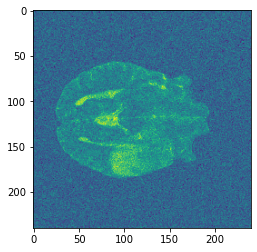

In [30]:
plt.imshow(data["x"][3, 0])
plt.show()

In [31]:
list(data["x"].shape)

[4, 1, 240, 240]

In [32]:
assert list(data["x"].shape) == [4, 1, 240, 240], "Error in data loader."

# Train loop

In [33]:
df_temp = df.sample(n=10).reset_index(drop=True).copy()
df_temp.head()

,patient_id,x,y,target,slice_pixel_count,slice_tumor_pixel_count,slice,binary_target
0,BraTS2021_00569,Data/Slices/BraTS2021_00569/x/143.h5,Data/Slices/BraTS2021_00569/y/143.h5,BACKGROUND,0.0,0.0,143,0
1,BraTS2021_00456,Data/Slices/BraTS2021_00456/x/74.h5,Data/Slices/BraTS2021_00456/y/74.h5,MGMT - YES,16422.0,3460.0,74,1
2,BraTS2021_00778,Data/Slices/BraTS2021_00778/x/69.h5,Data/Slices/BraTS2021_00778/y/69.h5,MGMT - NO,16806.0,840.0,69,0
3,BraTS2021_00088,Data/Slices/BraTS2021_00088/x/25.h5,Data/Slices/BraTS2021_00088/y/25.h5,BACKGROUND,3760.0,0.0,25,0
4,BraTS2021_00418,Data/Slices/BraTS2021_00418/x/121.h5,Data/Slices/BraTS2021_00418/y/121.h5,MGMT - NO,8071.0,656.0,121,0


In [34]:
train_loader = MRI_LoaderAugmentation(df_temp["x"], df_temp["target"], None)
train_loader = DataLoader(train_loader, shuffle=False, batch_size=2)

validation_loader = MRI_LoaderAugmentation(df_temp["x"], df_temp["target"], None)
validation_loader = DataLoader(validation_loader, shuffle=False, batch_size=2)

test_loader = MRI_LoaderAugmentation(df_temp["x"], df_temp["target"], None)
test_loader = DataLoader(test_loader, shuffle=False, batch_size=2)

In [35]:
target_per_patient = df.groupby("patient_id")["binary_target"].max().reset_index()

In [36]:
def generate_auc_hard(id_array, y_array, y_pred_array):
    
    df = pd.DataFrame(data={
        "patient_id": id_array,
        "y": y_array,
        "y_pred": y_pred_array
    })
        
    patients = pd.DataFrame(df["patient_id"].unique(), columns=["patient_id"])
        
    df = df[df["y_pred"] != 0].reset_index(drop=True)
    df["y_pred"] = df["y_pred"] - 1     
    
    y_pred_per_patient = df.groupby("patient_id")["y_pred"].mean().reset_index()

    df = patients.merge(target_per_patient, on="patient_id", how="inner").merge(y_pred_per_patient, on="patient_id", how="left")
    df = df.fillna(0)
        
    return roc_auc_score(df["binary_target"], df["y_pred"]), df

In [37]:
def generate_auc_soft(id_array, y_array, y_pred_array, y_score_0_array, y_score_1_array, y_score_2_array):
    
    df = pd.DataFrame(data={
        "patient_id": id_array,
        "y": y_array,
        "y_pred": y_pred_array,
        "y_pred_score_0": y_score_0_array,
        "y_pred_score_1": y_score_1_array,
        "y_pred_score_2": y_score_2_array,
    })
        
#     return df
        
    patients = pd.DataFrame(df["patient_id"].unique(), columns=["patient_id"])
        
    df = df[df["y_pred"] != 0].reset_index(drop=True)
    df["y_pred"] = df["y_pred"] - 1     
    
    y_pred_per_patient = df.groupby("patient_id").agg(pred_0=("y_pred_score_1", "mean"), pred_1=("y_pred_score_2", "mean")).reset_index()
    y_pred_per_patient["y_pred_score"] = y_pred_per_patient["pred_1"]/(y_pred_per_patient["pred_0"] + y_pred_per_patient["pred_1"])
    
#     y_pred_per_patient = df.groupby("patient_id")["y_pred"].mean().reset_index()

    df = patients.merge(target_per_patient, on="patient_id", how="inner").merge(y_pred_per_patient, on="patient_id", how="left")
    df = df.fillna(0)
        
    return roc_auc_score(df["binary_target"], df["y_pred_score"]), df

In [38]:
# df_sel = df_train_val[(df_train_val["slice"] > 100) & (df_train_val["slice"] < 120)].reset_index(drop=True)

train_loader = MRI_LoaderAugmentation(df_train_val["x"].iloc[:100], df_train_val["target"].iloc[:100], TR)
train_loader = DataLoader(train_loader, shuffle=False, batch_size=12)

validation_loader = MRI_LoaderAugmentation(df_val["x"], df_val["target"], None)
validation_loader = DataLoader(validation_loader, shuffle=False, batch_size=12)

test_loader = MRI_LoaderAugmentation(df_test["x"], df_test["target"], None)
test_loader = DataLoader(test_loader, shuffle=False, batch_size=2)

In [39]:
run = False

if run:
    
    net = resnet10(spatial_dims=2, n_input_channels=1, num_classes=3)

    net = net.to("cuda:0")

    epochs = 10
    loss = nn.CrossEntropyLoss()
    opt = optim.Adam(net.parameters())

    output_function = nn.Softmax(dim=0)
    
    for e in range(epochs):

        logger.info(f"Epoch: {e + 1}.")

        logger.info(f"Start training loop.")

        id_list = []
        y_list = []
        y_pred_list = []
        y_pred_score_0_list = []
        y_pred_score_1_list = []
        y_pred_score_2_list = []

        loss_value_per_step = 0

        net.train()    

        for data in train_loader:
            
            x = data["x"]
            y = data["y"]
            
            x = x.to("cuda:0")
            y = y.to("cuda:0")    
            
            opt.zero_grad()

            y_pred = net(x)

            loss_value = loss(y_pred, y)
            loss_value.backward()

            loss_value_per_step += loss_value.item()

            y_pred = output_function(net(x))
            
            opt.step()

            id_list_temp = list(data["id"])
            y_list_temp = list(y.detach().cpu().numpy().reshape(-1))
            y_pred_list_temp = list(torch.argmax(y_pred, dim=1).detach().cpu().numpy().reshape(-1))
            y_pred_score_0_list_temp = list(y_pred[:, 0].detach().cpu().numpy().reshape(-1))
            y_pred_score_1_list_temp = list(y_pred[:, 1].detach().cpu().numpy().reshape(-1))
            y_pred_score_2_list_temp = list(y_pred[:, 2].detach().cpu().numpy().reshape(-1))
               
            id_list += id_list_temp
            y_list += y_list_temp
            y_pred_list += y_pred_list_temp
            y_pred_score_0_list += y_pred_score_0_list_temp
            y_pred_score_1_list += y_pred_score_1_list_temp
            y_pred_score_2_list += y_pred_score_2_list_temp     
            
        id_list_array = np.array(id_list)
        y_array = np.array(y_list)
        y_pred_array = np.array(y_pred_list)
        y_pred_score_0_array = np.array(y_pred_score_0_list)
        y_pred_score_1_array = np.array(y_pred_score_1_list)
        y_pred_score_2_array = np.array(y_pred_score_2_list)
                
        auc_train = generate_auc_soft(id_list_array, y_array, y_pred_array, y_pred_score_0_array, y_pred_score_1_array, y_pred_score_2_array),
        
        break
        
        train_loop_info = {
            "step": e,
            "loss": loss_value_per_step/len(train_loader),
            "auc_train": auc_train
        }

        logger.info(f"Train loop info: {train_loop_info}")

        logger.info(f"Start validation loop.")

        id_list = []
        y_list = []
        y_pred_list = []

        loss_value_per_step = 0

        net.eval()

        for data in validation_loader:
            
            x = data["x"]
            y = data["y"]
            
            x = x.to("cuda:0")
            y = y.to("cuda:0")    
            
            with torch.no_grad():
                y_pred = output_function(net(x))
                loss_value = loss(y_pred, y)

            loss_value_per_step += loss_value.item()

            id_list_temp = list(data["id"])
            y_list_temp = list(y.detach().cpu().numpy().reshape(-1))
            y_pred_list_temp = list(torch.argmax(y_pred, dim=1).detach().cpu().numpy().reshape(-1))
            
            id_list += id_list_temp
            y_list += y_list_temp
            y_pred_list += y_pred_list_temp

        id_list_array = np.array(id_list)
        y_array = np.array(y_list)
        y_pred_array = np.array(y_pred_list)

        auc_test = generate_auc_hard(id_list_array, y_array, y_pred_array)

        validation_loop_info = {
            "step": e,
            "loss": loss_value_per_step/len(validation_loader),
            "auc": auc_test
        }

        logger.info(f"Validation loop info: {validation_loop_info}")
        
        break
        
        logger.info(f"Start test loop.")

        id_list = []
        y_list = []
        y_pred_list = []

        loss_value_per_step = 0

        net.eval()

        for data in test_loader:
            
            x = data["x"]
            y = data["y"]
            
            x = x.to("cuda:0")
            y = y.to("cuda:0")    
            
            with torch.no_grad():
                y_pred = net(x)
                loss_value = loss(y_pred, y)

            loss_value_per_step += loss_value.item()

            y_pred = output_function(net(x))
            
            id_list_temp = list(data["id"])
            y_list_temp = list(y.detach().cpu().numpy().reshape(-1))
            y_pred_list_temp = list(torch.argmax(y_pred, dim=1).detach().cpu().numpy().reshape(-1))
            
            id_list += id_list_temp
            y_list += y_list_temp
            y_pred_list += y_pred_list_temp

        id_list_array = np.array(id_list)
        y_array = np.array(y_list)
        y_pred_array = np.array(y_pred_list)

        auc_test = generate_auc(id_list_array, y_array, y_pred_array)

        validation_loop_info = {
            "step": e,
            "loss": loss_value_per_step/len(test_loader),
            "auc": auc_test
        }

        logger.info(f"Test loop info: {validation_loop_info}")

In [40]:
def train_and_evaluation_loop(net, 
                              loss, 
                              opt, 
                              train_loader, 
                              validation_loader,
                              test_loader,
                              epochs=10, 
                              patient=10,
                              name="Test training method",
                              experiment_description="First tests.",
                              mode="dev"):
        
    if mode != "dev":
        project = "END-TO-END-2D-MODEL-BRATS-CORRECTED-LOSS"
        run = wandb.init(project=project, entity="felipesassi", name=name)
        wandb.watch(net)
        config = wandb.config
        config["experiment_description"] = "experiment_description"
        config["loss"] = str(loss)
        config["optimizer"] = str(opt)
        config["epochs"] = epochs
        config["patient"] = patient
        config["batch_size"] = train_loader.batch_size
        
    best_model = None
    best_loss_during_training = 999999999
    stop_train_counter = 0
    
    train_info = []
    val_info = []
    test_info = []
    
    output_function = nn.Softmax(dim=0)
        
    for e in range(epochs):

        logger.info(f"Epoch: {e + 1}.")

        logger.info(f"Start training loop.")
 
        id_list = []
        y_list = []
        y_pred_list = []
        y_pred_score_0_list = []
        y_pred_score_1_list = []
        y_pred_score_2_list = []

        loss_value_per_step = 0

#         Check this
        net.train()

        start_time = time.time()
        
        for data in train_loader:
            
            x = data["x"]
            y = data["y"]
            
            x = x.to("cuda:0")
            y = y.to("cuda:0")    

            opt.zero_grad()

            y_pred = net(x)
                
            loss_value = loss(y_pred, y)
            
            loss_value.backward()

            loss_value_per_step += loss_value.item()

            opt.step()

            y_pred = output_function(net(x))
            
            id_list_temp = list(data["id"])
            y_list_temp = list(y.detach().cpu().numpy().reshape(-1))
            y_pred_list_temp = list(torch.argmax(y_pred, dim=1).detach().cpu().numpy().reshape(-1))
            y_pred_score_0_list_temp = list(y_pred[:, 0].detach().cpu().numpy().reshape(-1))
            y_pred_score_1_list_temp = list(y_pred[:, 1].detach().cpu().numpy().reshape(-1))
            y_pred_score_2_list_temp = list(y_pred[:, 2].detach().cpu().numpy().reshape(-1))
               
            id_list += id_list_temp
            y_list += y_list_temp
            y_pred_list += y_pred_list_temp
            y_pred_score_0_list += y_pred_score_0_list_temp
            y_pred_score_1_list += y_pred_score_1_list_temp
            y_pred_score_2_list += y_pred_score_2_list_temp
            
        end_time = time.time()
            
        id_list_array = np.array(id_list)
        y_array = np.array(y_list)
        y_pred_array = np.array(y_pred_list)
        y_pred_score_0_array = np.array(y_pred_score_0_list)
        y_pred_score_1_array = np.array(y_pred_score_1_list)
        y_pred_score_2_array = np.array(y_pred_score_2_list)
        
        train_loop_info = {
            "step": e,
            "loss_train": loss_value_per_step/len(train_loader),
            "auc_train_hard": generate_auc_hard(id_list_array, y_array, y_pred_array)[0],
            "auc_train_soft": generate_auc_soft(id_list_array, y_array, y_pred_array, y_pred_score_0_array, y_pred_score_1_array, y_pred_score_2_array)[0],
            "train_loop_duration": end_time - start_time,
            "train_data":  wandb.Table(dataframe=pd.DataFrame(data={"id": id_list, "pred": y_pred_array, "target": y_array}))
        }
        
        train_info.append({
            "hard": generate_auc_hard(id_list_array, y_array, y_pred_array)[1],
            "soft": generate_auc_soft(id_list_array, y_array, y_pred_array, y_pred_score_0_array, y_pred_score_1_array, y_pred_score_2_array)[1],
        })
            
        if mode != "dev":
            wandb.log(train_loop_info)
        
        logger.info(f"Train loop info: {train_loop_info}")
        
#         if e == 0:
        
#             first_epoch_loss = loss_value_per_step/len(train_loader)
        
#         if first_epoch_loss < generate_auc_hard(id_list_array, y_array, y_pred_array):
#             break
            
#         if (generate_auc_hard(id_list_array, y_array, y_pred_array)[0] > 0.75) or (generate_auc_soft(id_list_array, y_array, y_pred_array, y_pred_score_0_array, y_pred_score_1_array, y_pred_score_2_array)[0] > 0.75):
#             break
        
        logger.info(f"Start validation loop.")

        id_list = []
        y_list = []
        y_pred_list = []
        y_pred_score_0_list = []
        y_pred_score_1_list = []
        y_pred_score_2_list = []

        loss_value_per_step = 0
        
#         Check this
        net.eval()

        start_time = time.time()
        
        for data in validation_loader:
            
            x = data["x"]
            y = data["y"]
            
            x = x.to("cuda:0")
            y = y.to("cuda:0")    

            with torch.no_grad():
                y_pred = net(x)
                loss_value = loss(y_pred, y)

            loss_value_per_step += loss_value.item()

            y_pred = output_function(net(x))
            
            id_list_temp = list(data["id"])
            y_list_temp = list(y.detach().cpu().numpy().reshape(-1))
            y_pred_list_temp = list(torch.argmax(y_pred, dim=1).detach().cpu().numpy().reshape(-1))
            
            id_list_temp = list(data["id"])
            y_list_temp = list(y.detach().cpu().numpy().reshape(-1))
            y_pred_list_temp = list(torch.argmax(y_pred, dim=1).detach().cpu().numpy().reshape(-1))
            y_pred_score_0_list_temp = list(y_pred[:, 0].detach().cpu().numpy().reshape(-1))
            y_pred_score_1_list_temp = list(y_pred[:, 1].detach().cpu().numpy().reshape(-1))
            y_pred_score_2_list_temp = list(y_pred[:, 2].detach().cpu().numpy().reshape(-1))
               
            id_list += id_list_temp
            y_list += y_list_temp
            y_pred_list += y_pred_list_temp
            y_pred_score_0_list += y_pred_score_0_list_temp
            y_pred_score_1_list += y_pred_score_1_list_temp
            y_pred_score_2_list += y_pred_score_2_list_temp
            
        end_time = time.time()
            
        id_list_array = np.array(id_list)
        y_array = np.array(y_list)
        y_pred_array = np.array(y_pred_list)
        y_pred_score_0_array = np.array(y_pred_score_0_list)
        y_pred_score_1_array = np.array(y_pred_score_1_list)
        y_pred_score_2_array = np.array(y_pred_score_2_list)
        
        validation_loop_info = {
            "step": e,
            "loss_validation": loss_value_per_step/len(validation_loader),
            "auc_validation_hard": generate_auc_hard(id_list_array, y_array, y_pred_array)[0],
            "auc_validation_soft": generate_auc_soft(id_list_array, y_array, y_pred_array, y_pred_score_0_array, y_pred_score_1_array, y_pred_score_2_array)[0],
            "validation_loop_duration": end_time - start_time,
            "validation_data":  wandb.Table(dataframe=pd.DataFrame(data={"id": id_list, 
                                                                   "pred": y_pred_array, 
                                                                   "target": y_array,
                                                                   "score_0": y_pred_score_0_array,
                                                                   "score_1": y_pred_score_1_array,
                                                                   "score_2": y_pred_score_2_array,    
                                                                  }))
        }

        val_info.append({
            "hard": generate_auc_hard(id_list_array, y_array, y_pred_array)[1],
            "soft": generate_auc_soft(id_list_array, y_array, y_pred_array, y_pred_score_0_array, y_pred_score_1_array, y_pred_score_2_array)[1],
        })
        
        if mode != "dev":
            wandb.log(validation_loop_info)
        
        logger.info(f"Validation loop info: {validation_loop_info}")
    
#         #Early stopping 
#         if loss_value_per_step < best_loss_during_training:
#             best_loss_during_training = loss_value_per_step
#             stop_train_counter = 0
            
#             if not os.path.exists(f"Data/Models/{project}"):
#                 os.mkdir(f"Data/Models/{project}")
            
#             torch.save(net, f"Data/Models/{project}/{'_'.join(name.split(' ')).lower()}.pth")
            
#             logger.info(f"New loss lower than best loss - New best loss: {loss_value_per_step:.2f}")
            
#         else:
#             stop_train_counter = stop_train_counter + 1
            
#         if stop_train_counter >= patient:
#             logger.info(f"Stop training in epoch {e}.")
#             break
        
#         if mode != "dev":
#             if not os.path.exists(f"Data/Models/{project}"):
#                 os.mkdir(f"Data/Models/{project}")
            
#             torch.save(net, f"Data/Models/{project}/{'_'.join(name.split(' ')).lower()}.pth")


        logger.info(f"Start test loop.")

        id_list = []
        y_list = []
        y_pred_list = []
        y_pred_score_0_list = []
        y_pred_score_1_list = []
        y_pred_score_2_list = []

        loss_value_per_step = 0

        net.eval()

        start_time = time.time()

        for data in test_loader:

            x = data["x"]
            y = data["y"]

            x = x.to("cuda:0")
            y = y.to("cuda:0")    

            with torch.no_grad():
                y_pred = net(x)
                loss_value = loss(y_pred, y)

            loss_value_per_step += loss_value.item()

            y_pred = output_function(net(x))
            
            id_list_temp = list(data["id"])
            y_list_temp = list(y.detach().cpu().numpy().reshape(-1))
            y_pred_list_temp = list(torch.argmax(y_pred, dim=1).detach().cpu().numpy().reshape(-1))

            id_list_temp = list(data["id"])
            y_list_temp = list(y.detach().cpu().numpy().reshape(-1))
            y_pred_list_temp = list(torch.argmax(y_pred, dim=1).detach().cpu().numpy().reshape(-1))
            y_pred_score_0_list_temp = list(y_pred[:, 0].detach().cpu().numpy().reshape(-1))
            y_pred_score_1_list_temp = list(y_pred[:, 1].detach().cpu().numpy().reshape(-1))
            y_pred_score_2_list_temp = list(y_pred[:, 2].detach().cpu().numpy().reshape(-1))
               
            id_list += id_list_temp
            y_list += y_list_temp
            y_pred_list += y_pred_list_temp
            y_pred_score_0_list += y_pred_score_0_list_temp
            y_pred_score_1_list += y_pred_score_1_list_temp
            y_pred_score_2_list += y_pred_score_2_list_temp
            
        end_time = time.time()
            
        id_list_array = np.array(id_list)
        y_array = np.array(y_list)
        y_pred_array = np.array(y_pred_list)
        y_pred_score_0_array = np.array(y_pred_score_0_list)
        y_pred_score_1_array = np.array(y_pred_score_1_list)
        y_pred_score_2_array = np.array(y_pred_score_2_list)

        test_loop_info = {
            "step": e,
            "loss_test": loss_value_per_step/len(test_loader),
            "auc_test_hard": generate_auc_hard(id_list_array, y_array, y_pred_array)[0],
            "auc_test_soft": generate_auc_soft(id_list_array, y_array, y_pred_array, y_pred_score_0_array, y_pred_score_1_array, y_pred_score_2_array)[0],
            "test_loop_duration": end_time - start_time,
            "test_data":  wandb.Table(dataframe=pd.DataFrame(data={"id": id_list, 
                                                                   "pred": y_pred_array, 
                                                                   "target": y_array,
                                                                   "score_0": y_pred_score_0_array,
                                                                   "score_1": y_pred_score_1_array,
                                                                   "score_2": y_pred_score_2_array,    
                                                                  }))
        }

        test_info.append({
            "hard": generate_auc_hard(id_list_array, y_array, y_pred_array)[1],
            "soft": generate_auc_soft(id_list_array, y_array, y_pred_array, y_pred_score_0_array, y_pred_score_1_array, y_pred_score_2_array)[1],
        })
        
        if mode != "dev":
            wandb.log(test_loop_info)

        logger.info(f"Test loop info: {test_loop_info}")

    if mode != "dev":    
        run.finish()
        
    return train_info, val_info, test_info


# Experiments

In [45]:
PROB = 0.75

TR = transforms.Compose(
    [
        transforms.RandZoom(prob=PROB, min_zoom=0.5, max_zoom=1.75), #OK
        transforms.RandGaussianNoise(prob=PROB, mean=250, std=250), #OK
        transforms.RandRotate(prob=PROB, 
                              range_x=10*np.pi/180,
                              range_y=10*np.pi/180,
                             )
     ]
)

In [48]:
BATCH_SIZE = 16
    
WEIGHT_DECAY = 1e-4
    
for lr in [1e-3]:

    net = resnet34(spatial_dims=2, n_input_channels=1, num_classes=3)

    net = net.to("cuda:0")
    net.train()

    epochs = 15
    loss = nn.CrossEntropyLoss()
    opt = optim.Adam(net.parameters(), lr=lr, weight_decay=WEIGHT_DECAY)

    train_loader = MRI_LoaderAugmentation(df_train_val["x"], df_train_val["target"], TR)
    train_loader = DataLoader(train_loader, shuffle=False, batch_size=BATCH_SIZE, num_workers=16)

    validation_loader = MRI_LoaderAugmentation(df_val["x"], df_val["target"], None)
    validation_loader = DataLoader(validation_loader, shuffle=False, batch_size=BATCH_SIZE, num_workers=16)

    test_loader = MRI_LoaderAugmentation(df_test["x"], df_test["target"], None)
    test_loader = DataLoader(test_loader, shuffle=False, batch_size=BATCH_SIZE, num_workers=16)

    train_info, val_info, test_info = train_and_evaluation_loop(net,
                              loss,
                              opt,
                              train_loader,
                              validation_loader,
                              test_loader, 
                              epochs, 
                              100, 
                              mode="prod", 
                              name=f"Baseline - ResNet34 - 15 epochs - Batch size {BATCH_SIZE} - Learning rate {lr} - 30% das fatias removidas e remoção de fatias com pouco tumor - Com data augmentation e weight decay {WEIGHT_DECAY}")

wandb: wandb version 0.13.3 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


2022-10-02 17:44:21.617 | INFO     | __main__:train_and_evaluation_loop:37 - Epoch: 1.
2022-10-02 17:44:21.618 | INFO     | __main__:train_and_evaluation_loop:39 - Start training loop.
2022-10-02 17:48:09.359 | INFO     | __main__:train_and_evaluation_loop:117 - Train loop info: {'step': 0, 'loss_train': 0.9441279845338472, 'auc_train_hard': 0.5956218564243256, 'auc_train_soft': 0.604061880810852, 'train_loop_duration': 223.27677035331726, 'train_data': <wandb.data_types.Table object at 0x7f93e17ccaf0>}
2022-10-02 17:48:09.362 | INFO     | __main__:train_and_evaluation_loop:129 - Start validation loop.
2022-10-02 17:48:54.715 | INFO     | __main__:train_and_evaluation_loop:211 - Validation loop info: {'step': 0, 'loss_validation': 1.0783051370901853, 'auc_validation_hard': 0.45908289241622574, 'auc_validation_soft': 0.4772486772486772, 'validation_loop_duration': 41.25619888305664, 'validation_data': <wandb.data_types.Table object at 0x7f93dc4198b0>}
2022-10-02 17:48:54.716 | INFO     

step,14
loss_train,0.57169
auc_train_hard,0.81028
auc_train_soft,0.82091
train_loop_duration,222.29834
_runtime,4963
_timestamp,1664748418
_step,44
loss_validation,0.7091
auc_validation_hard,0.60123
auc_validation_soft,0.59436


step,▁▁▁▁▁▁▂▂▃▃▃▃▃▃▃▃▄▄▄▅▅▅▅▅▅▅▅▆▆▆▇▇▇▇▇▇▇▇██
loss_train,█▅▄▄▄▃▃▃▂▂▂▂▂▁▁
auc_train_hard,▂▁▂▃▃▃▃▃▃▄▄▅▆▇█
auc_train_soft,▁▁▂▂▂▂▃▃▃▄▄▅▆▇█
train_loop_duration,█▇▄▃▅▄▅▁▅▂▄▁▂▂▂
_runtime,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
_timestamp,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss_validation,█▅▅▆▂▁▁▁▁▁▁▁▁▂▂
auc_validation_hard,▁▃▃▃▃▄▄▅▅▆▆▇▆██
auc_validation_soft,▁▂▁▂▂▄▄▄▅▅▅▇▆██
